In [1]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(current_directory)

# Change to the parent directory
os.chdir(parent_directory)

# Verify the change
new_directory = os.getcwd()
print(f"Changed working directory to: {new_directory}")


Changed working directory to: c:\Users\fools\Quest


In [2]:
from collections import deque
import json

def extract_symbol_interval(filename):
    parts = filename.split('_')
    symbol = parts[0]
    interval = parts[1].split('.')[0]  # Remove '.csv'
    return symbol, interval

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def extract_symbol_info(filename):
    data_folder = os.path.join('data')
    candles_folder = os.path.join(data_folder, 'candles')
    symbols_folder = os.path.join(data_folder, 'symbols')

    csv_filename = filename
    candles_file_path = os.path.join(candles_folder, csv_filename)

    if not os.path.exists(candles_file_path):
        print(f"File {csv_filename} does not exist in the directory.")
        return None
    else:
        symbol, interval = extract_symbol_interval(csv_filename)

        with open(candles_file_path, newline='') as csvfile:
            reader = csv.reader(csvfile)
            last_row = deque(reader, maxlen=1)[0]
        end_value = last_row[1]  # Last 'end' value

        symbol_json_file = f"{symbol}.json"
        symbol_file_path = os.path.join(symbols_folder, symbol_json_file)

        if os.path.exists(symbol_file_path):
            symbol_data = read_json_file(symbol_file_path)
            # Extract JSON data
            symbol_description = symbol_data['description']
            symbol_id = symbol_data['symbolId']
            security_type = symbol_data['securityType']
            listing_exchange = symbol_data['listingExchange']
            is_tradable = symbol_data['isTradable']
            is_quotable = symbol_data['isQuotable']
            currency = symbol_data['currency']

            # Return the extracted data
            return symbol, interval, end_value, symbol_description, symbol_id, security_type, listing_exchange, is_tradable, is_quotable, currency

        else:
            print(f"No JSON data available for {symbol}")
            return symbol, interval, end_value


In [11]:
def calculate_technical_indicators(data):
    data['start'] = pd.to_datetime(data['start'], utc=True)
    # Drop the 'end' column from the DataFrame
    data.drop(columns=['end'], inplace=True)

    # Parameters for various indicators
    ema_params = [10, 30, 50, 100, 200]
    sma_params = [10, 30, 50, 100, 200]
    rolling_window = 20
    ema_short_span = 12
    ema_long_span = 26
    rsi_window = 14
    macd_signal_span = 9

    # Calculate SMA and EMA using loops
    for param in sma_params:
        data[f'SMA_{param}'] = data['close'].rolling(window=param).mean()

    for param in ema_params:
        data[f'EMA_{param}'] = data['close'].ewm(span=param, adjust=False).mean()

    # Calculate Bollinger Bands
    rolling_std = data['close'].rolling(window=rolling_window).std()
    data['middle_BB'] = data['close'].rolling(window=rolling_window).mean()
    data['upper_BB'] = data['middle_BB'] + 2 * rolling_std
    data['lower_BB'] = data['middle_BB'] - 2 * rolling_std

    # Calculate RSI
    delta = data['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=rsi_window).mean()
    avg_loss = loss.rolling(window=rsi_window).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Calculate MACD
    ema_short = data['close'].ewm(span=ema_short_span, adjust=False).mean()
    ema_long = data['close'].ewm(span=ema_long_span, adjust=False).mean()
    data['MACD'] = ema_short - ema_long
    data['MACD_signal'] = data['MACD'].ewm(span=macd_signal_span, adjust=False).mean()
    data['MACD_hist'] = data['MACD'] - data['MACD_signal']

    # Clean data by dropping NaN values
    data.dropna(inplace=True)

    # Defining target variables by shifting future prices
    data['next_high'] = data['high'].shift(-1)
    data['next_low'] = data['low'].shift(-1)

    # Set 'start' column as the index
    data.set_index('start', inplace=True)

    return data

def prepare_train_test_data(data):
    '''
    # Example usage:
    (X_train_high, X_test_high, y_train_high, y_test_high), (X_train_low, X_test_low, y_train_low, y_test_low) = prepare_train_test_data(data)
    '''
    # Dropping the rows with NaN values for 'next_high' and 'next_low'
    data.dropna(subset=['next_high', 'next_low'], inplace=True)

    # Separating the features and target variables
    features = data.drop(columns=['next_high', 'next_low'])
    targets_high = data['next_high']
    targets_low = data['next_low']

    # Splitting the data into training and testing sets (80% training, 20% testing)
    train_size = int(0.85 * len(data))
    X_train, X_test = features[:train_size], features[train_size:]
    y_train_high, y_test_high = targets_high[:train_size], targets_high[train_size:]
    y_train_low, y_test_low = targets_low[:train_size], targets_low[train_size:]

    return (X_train, X_test, y_train_high, y_test_high), (X_train, X_test, y_train_low, y_test_low)

def train_evaluate_xgboost_model(X_train, y_train, X_test, y_test):
    '''
    Command to use:
    # Train and evaluate the XGBoost model for high prices
    model_high, mae_high, rmse_high, avg_mae_cv_high = train_evaluate_xgboost_model(X_train_high, y_train_high, X_test_high, y_test_high)

    # Train and evaluate the XGBoost model for low prices
    model_low, mae_low, rmse_low, avg_mae_cv_low = train_evaluate_xgboost_model(X_train_low, y_train_low, X_test_low, y_test_low)

    '''
    model = XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1, random_state=42)

    # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    avg_mae_cv = -np.mean(cv_scores)

    # Train the model on the full training set
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    return model, mae, rmse, avg_mae_cv

def train_predict_plot(X_train_high, y_train_high, X_train_low, y_train_low, 
                       X_test_high, y_test_high, X_test_low, y_test_low 
                       ):
    # Assuming train_evaluate_xgboost_model and send_discord_alert are defined elsewhere

    # Train and predict for high prices
    model_high, _, _, _ = train_evaluate_xgboost_model(X_train_high, y_train_high, X_test_high, y_test_high)
    predictions_high = model_high.predict(X_test_high)

    # Train and predict for low prices
    model_low, _, _, _ = train_evaluate_xgboost_model(X_train_low, y_train_low, X_test_low, y_test_low)
    predictions_low = model_low.predict(X_test_low)

    # Creating the plot
    plt.figure(figsize=(15, 8))

    # Plot actual high and low prices
    plt.plot(y_test_high.index, y_test_high, color='blue', label='Actual Band')
    plt.plot(y_test_low.index, y_test_low, color='blue')
    plt.fill_between(y_test_high.index, y_test_high, y_test_low, facecolor='blue', alpha=0.2)

    # Plot predicted high and low prices
    plt.plot(y_test_high.index, predictions_high, linestyle='dashed', color='red', label='Predicted Band')
    plt.plot(y_test_low.index, predictions_low, linestyle='dashed', color='red')
    plt.fill_between(y_test_high.index, predictions_high, predictions_low, facecolor='red', alpha=0.2)

    # Flagging logic for anomalies
    flags_high = (y_test_high > predictions_high * 1.01)
    flagged_indices_high = y_test_high.index[flags_high]

    flags_low = (y_test_low < predictions_low * 0.99)
    flagged_indices_low = y_test_low.index[flags_low]

    # Plot flagged points
    plt.scatter(flagged_indices_high, y_test_high[flags_high], color='red', label='Sell')
    plt.scatter(flagged_indices_low, y_test_low[flags_low], color='green', label='Buy')

    # Plot enhancements
    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


    return model_high, predictions_high, model_low, predictions_low, flagged_indices_high, flagged_indices_low


Processing AON PLC (IE)
                                      low      high      open    close  \
start                                                                    
2023-10-23 17:56:00.555000+00:00  313.210  313.2600  313.2600  313.210   
2023-10-23 17:57:00.555000+00:00  313.040  313.1500  313.1500  313.130   
2023-10-23 17:58:00.555000+00:00  313.015  313.1900  313.1900  313.015   
2023-10-23 17:59:00.555000+00:00  312.850  312.9947  312.9947  312.970   
2023-10-23 18:00:00.555000+00:00  313.000  313.1000  313.0900  313.000   

                                  volume        VWAP    SMA_10      SMA_30  \
start                                                                        
2023-10-23 17:56:00.555000+00:00     700  313.811855  313.4040  313.457627   
2023-10-23 17:57:00.555000+00:00    1100  313.805113  313.3695  313.447627   
2023-10-23 17:58:00.555000+00:00     590  313.801563  313.3235  313.431127   
2023-10-23 17:59:00.555000+00:00    1173  313.792684  313.2645  313

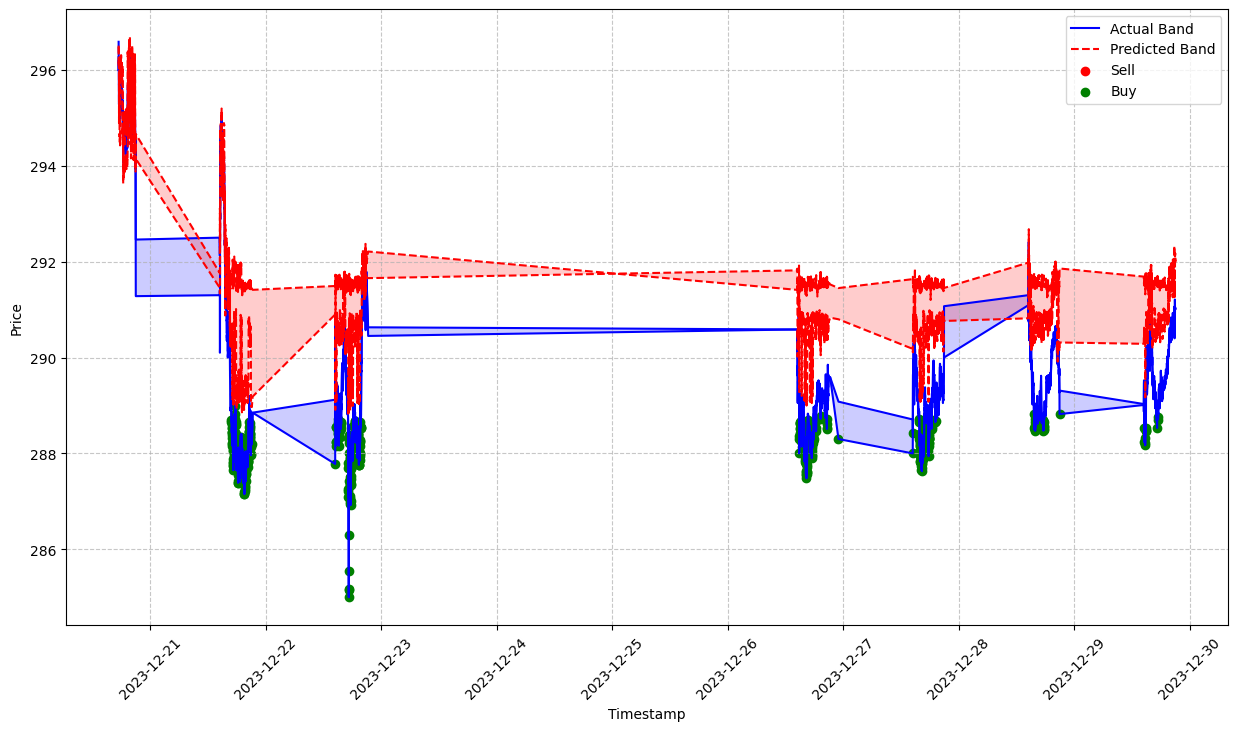

Processing BANK OF MONTREAL
                                     low    high    open   close  volume  \
start                                                                      
2023-10-23 16:50:00.775000+00:00  106.98  107.02  107.01  106.98    8100   
2023-10-23 16:51:00.775000+00:00  106.98  107.01  106.98  107.00    1600   
2023-10-23 16:52:00.775000+00:00  106.99  107.03  106.99  107.03    6300   
2023-10-23 16:53:00.775000+00:00  107.01  107.03  107.02  107.03    2100   
2023-10-23 16:54:00.775000+00:00  107.01  107.10  107.01  107.05    3100   

                                        VWAP   SMA_10      SMA_30    SMA_50  \
start                                                                         
2023-10-23 16:50:00.775000+00:00  105.951502  107.014  107.070000  107.1260   
2023-10-23 16:51:00.775000+00:00  105.953891  107.007  107.069667  107.1220   
2023-10-23 16:52:00.775000+00:00  105.963315  107.008  107.067000  107.1178   
2023-10-23 16:53:00.775000+00:00  105.966422

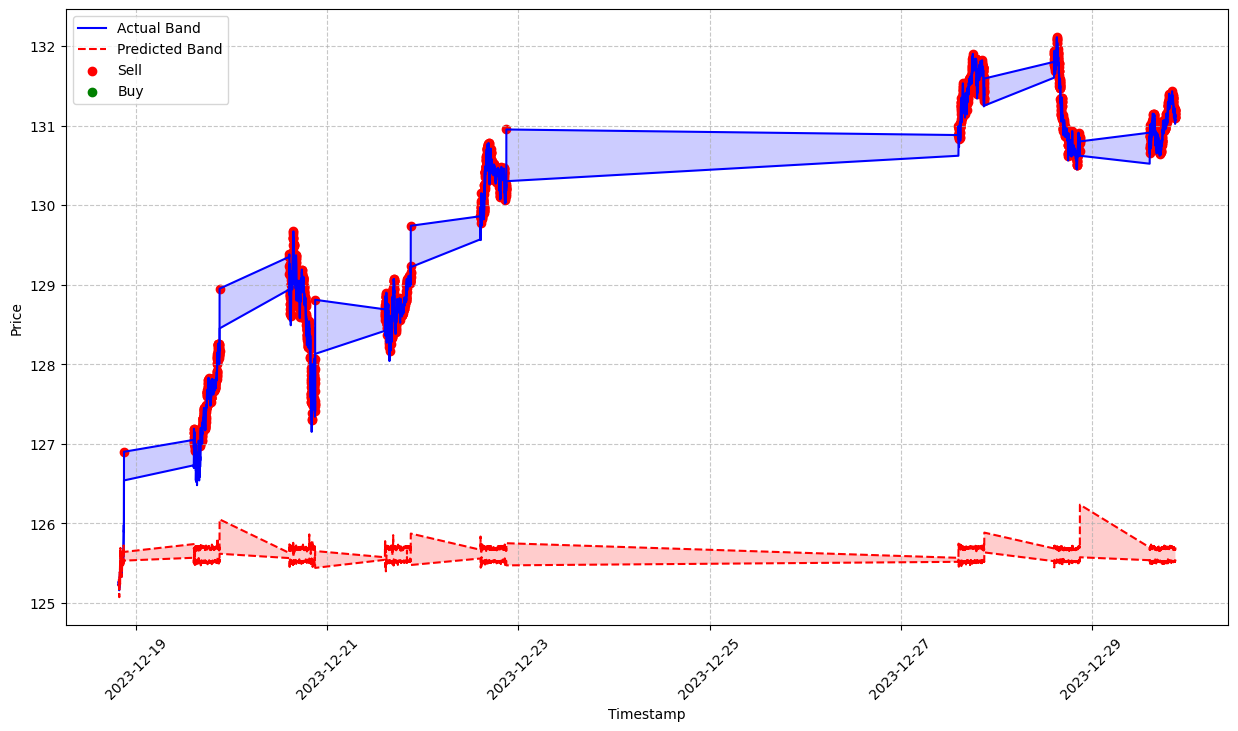

Processing CI GALAXY BITCOIN ETF CAD UNHEDGED ETF UNITS
                                   low  high  open  close  volume      VWAP  \
start                                                                         
2023-10-24 16:09:00.815000+00:00  6.90  6.91  6.90   6.91     600  6.954961   
2023-10-24 16:10:00.815000+00:00  6.90  6.91  6.91   6.90    1900  6.954647   
2023-10-24 16:12:00.815000+00:00  6.91  6.91  6.91   6.91    2000  6.954348   
2023-10-24 16:14:00.815000+00:00  6.90  6.90  6.90   6.90    1100  6.954150   
2023-10-24 16:17:00.815000+00:00  6.92  6.92  6.92   6.92    3000  6.953799   

                                  SMA_10    SMA_30  SMA_50  SMA_100  ...  \
start                                                                ...   
2023-10-24 16:09:00.815000+00:00   6.863  6.873333  6.9292   6.8970  ...   
2023-10-24 16:10:00.815000+00:00   6.867  6.871333  6.9276   6.9024  ...   
2023-10-24 16:12:00.815000+00:00   6.871  6.870667  6.9258   6.9079  ...   
2023-10-24

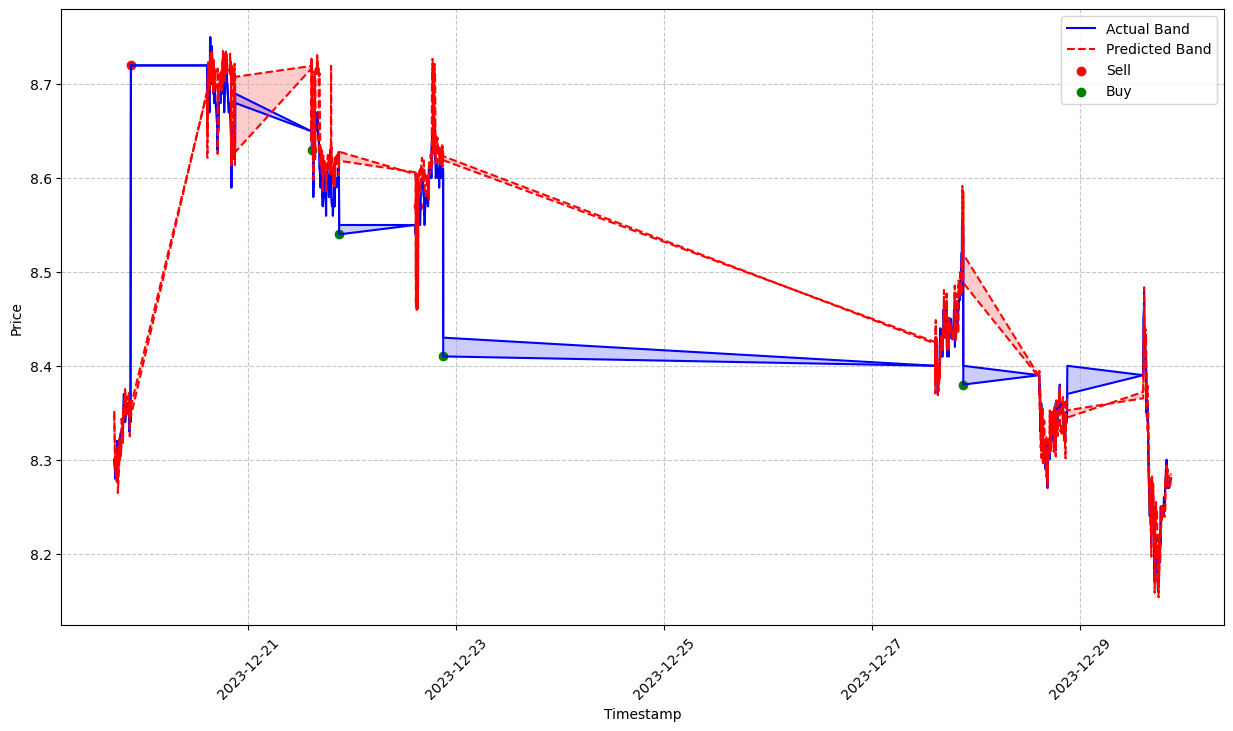

Processing CI GOLD+ GIANTS COVERED CALL E HEDGED COMMON UNITS
                                   low  high  open  close  volume      VWAP  \
start                                                                         
2023-11-14 14:44:00.449000+00:00  9.56  9.56  9.56   9.56     500  9.470443   
2023-11-14 14:57:00.449000+00:00  9.58  9.58  9.58   9.58     200  9.492095   
2023-11-14 14:59:00.449000+00:00  9.57  9.57  9.57   9.57     200  9.504950   
2023-11-14 15:03:00.449000+00:00  9.56  9.56  9.56   9.56     400  9.518610   
2023-11-14 15:04:00.449000+00:00  9.55  9.55  9.55   9.55    2000  9.535991   

                                  SMA_10    SMA_30  SMA_50  SMA_100  ...  \
start                                                                ...   
2023-11-14 14:44:00.449000+00:00   9.317  9.311333  9.3728   9.5763  ...   
2023-11-14 14:57:00.449000+00:00   9.344  9.320333  9.3762   9.5723  ...   
2023-11-14 14:59:00.449000+00:00   9.371  9.328667  9.3796   9.5680  ...   
2023

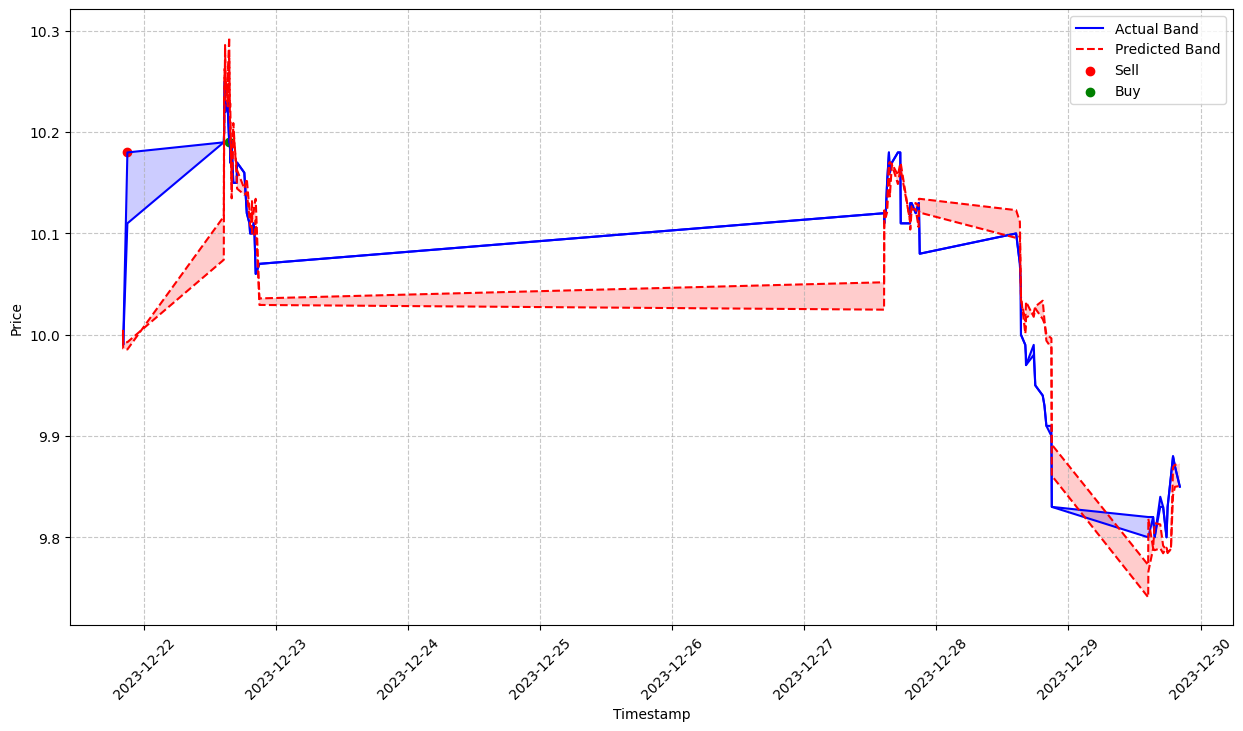

Processing CITIGROUP INC
                                     low   high    open   close  volume  \
start                                                                     
2023-10-23 16:36:00.868000+00:00  39.265  39.29  39.290  39.280   15241   
2023-10-23 16:37:00.868000+00:00  39.285  39.31  39.285  39.310   14760   
2023-10-23 16:38:00.868000+00:00  39.300  39.32  39.310  39.305   15965   
2023-10-23 16:39:00.868000+00:00  39.295  39.32  39.310  39.315    7290   
2023-10-23 16:40:00.868000+00:00  39.300  39.33  39.310  39.310   16854   

                                       VWAP    SMA_10     SMA_30     SMA_50  \
start                                                                         
2023-10-23 16:36:00.868000+00:00  39.308660  39.29294  39.282730  39.339516   
2023-10-23 16:37:00.868000+00:00  39.308639  39.29494  39.279563  39.337714   
2023-10-23 16:38:00.868000+00:00  39.308641  39.29594  39.276230  39.335214   
2023-10-23 16:39:00.868000+00:00  39.308637  39.29594 

In [19]:
import os
import pandas as pd
import csv
from collections import deque
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt
import json

def process_all_files(directory):
    """
    Process all CSV files in the specified directory.

    Args:
    directory (str): The directory containing the CSV files.

    Returns:
    None
    """
    # Iterate over each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            # Construct the full file path
            file_path = os.path.join(directory, filename)
            info = extract_symbol_info(filename)
            symbol, interval, end_value, symbol_description, symbol_id, security_type, listing_exchange, is_tradable, is_quotable, currency = info
            print(f"Processing {symbol_description}")
            # Add your custom code here to process each file
            # Example: print(f"Processing {file_path}")
            data = pd.read_csv(file_path)  # Use the combined file path
            # Your custom code goes here
            data = calculate_technical_indicators(data)
            print(data.head())
            print('WORKING..Please be patient..')
            (X_train_high, X_test_high, y_train_high, y_test_high), (X_train_low, X_test_low, y_train_low, y_test_low) = prepare_train_test_data(data)
            # Train and evaluate the XGBoost model for high prices
            model_high, mae_high, rmse_high, avg_mae_cv_high = train_evaluate_xgboost_model(X_train_high, y_train_high, X_test_high, y_test_high)
            # Train and evaluate the XGBoost model for low prices
            model_low, mae_low, rmse_low, avg_mae_cv_low = train_evaluate_xgboost_model(X_train_low, y_train_low, X_test_low, y_test_low)

            train_predict_plot(X_train_high, y_train_high, X_train_low, y_train_low, 
                                X_test_high, y_test_high, X_test_low, y_test_low
                                )
            pass  # Remove this after adding your code

# Example usage
process_all_files('data\candles')
